Importando bibliotecas e datasets:

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import statsmodels.api as sm

In [78]:
dados = pd.read_table('seguros.csv', encoding="UTF", sep=",")
dados.columns = ['Idade','Sexo', 'IMC','Filhos', 'Fumante', 'Regiao', 'Despesas']

#Remove colunas desnecessárias
dados.drop('Regiao', axis=1, inplace=True) 

#Convertendo Sexo para inteiros // 0 = homem, 1 = mulher
dados.loc[dados[dados.Sexo=="male"].index,"Sexo"] = 0
dados.loc[dados[dados.Sexo=="female"].index,"Sexo"] = 1

#Convertendo Fumante para inteiros // 0 = não fumante, 1 = fumante
dados.loc[dados[dados.Fumante=="no"].index,"Fumante"] = 0
dados.loc[dados[dados.Fumante=="yes"].index,"Fumante"] = 1

#Convertendo IMC e Despesas
for i in range(len(dados)):
    dados.at[i,'IMC'] = round(dados.at[i,'IMC'], 1)
    dados.at[i,'Despesas'] = round(dados.at[i,'Despesas'], 0)
        
#Convertendo Despesas para inteiros
dados["Despesas"] = pd.to_numeric(dados["Despesas"], downcast="signed")

Lendo a tabela:

In [79]:
dados.head()

,Idade,Sexo,IMC,Filhos,Fumante,Despesas
0,19,1,27.9,0,1,16885
1,18,0,33.8,1,0,1726
2,28,0,33.0,3,0,4449
3,33,0,22.7,0,0,21984
4,32,0,28.9,0,0,3867


Parcela de fumantes:

In [80]:
fuma_ou_nao = dados.Fumante.value_counts(True)
print("Fumantes:", 100*round(fuma_ou_nao[0],4),"%"," |","Não Fumantes:", 100*round(fuma_ou_nao[1],4),"%")

Fumantes: 79.52 %  | Não Fumantes: 20.48 %


Histograma das despesas:

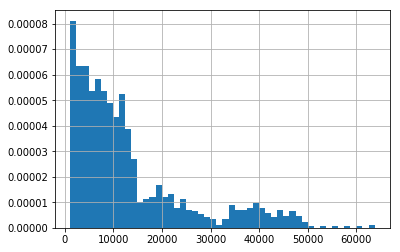

In [81]:
dados["Despesas"].hist(density=True, bins=50)

In [90]:
len(dados[(dados["Despesas"] < 15000)&(dados["Fumante"]==1)])

7

Número de Fumantes em cada faixa de valores:

In [89]:
dados["Despesas"] = a


p0a15 = len(dados[(dados["Despesas"] < 30000)&(dados["Fumante"] ==1)])
p15a30 =len(dados[(dados["Despesas"] > 15000)&(dados["Despesas"] < 30000)&(dados["Fumante"] ==1)])
print()

,Idade,Sexo,IMC,Filhos,Fumante,Despesas
0,19,1,27.9,0,1,16885
11,62,1,26.3,0,1,27809
52,48,0,28.0,1,1,23568
58,53,1,22.9,1,1,23245
69,28,0,24.0,3,1,17663
70,27,1,24.8,0,1,16578
85,45,0,22.9,2,1,21099
98,56,0,20.0,0,1,22413
99,38,0,19.3,0,1,15821
105,20,0,28.0,1,1,17560


Pelo Histograma podemos observar que se dividem em 4 categorias de despesas pela faixa de preço:<br>
Menos de 15mil, 15mil e 30mil, 30 mil e 50 mil e mais que 60mil

In [6]:
train = dados.sample(n=200)
fuma_ou_nao = train.Fumante.value_counts(True)
fuma_ou_nao

0    0.81
1    0.19
Name: Fumante, dtype: float64

In [7]:
dados.Fumante = dados.Fumante.astype('int')
x = dados.iloc[:,[0,1,2,3,5]]
y = dados.Fumante
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)

In [137]:
#y_train

In [138]:
sgd_clf = LogisticRegression()  # Existe aleatoriedade dentro do SGDClassifier.
sgd_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [140]:
teste = sgd_clf.predict(X_test)
y_pred = sgd_clf.predict(X_test)
print('Acurácia: {}'.format(accuracy_score(y_test, y_pred)))

Acurácia: 0.9477611940298507


In [105]:
varind = np.asarray(dados[["idade","sexo","IMC","Despesas"]])
varind = sm.add_constant(varind)
vardep = dados["Fumante"]
mod = sm.OLS(vardep.astype(float),varind.astype(float))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Fumante   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     835.3
Date:                Tue, 13 Nov 2018   Prob (F-statistic):               0.00
Time:                        15:23:17   Log-Likelihood:                 154.98
No. Observations:                1338   AIC:                            -300.0
Df Residuals:                    1333   BIC:                            -274.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4247      0.034     12.527      0.000       0.358       0.491
x1            -0.0080      0.000    -18.026      0.000      -0.009      -0.007
x2            -0.0208      0.012     -1.753      0.080      -0.044       0.002
x3            -0.0096      0.001     -9.707      0.000      -0.012      -0.008
x4          2.991e-05    5.2e-07     57.544      0.000    2.89e-05    3.09e-05
==============================================================================
Omnibus:                      105.643   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              470.723
Skew:                           0.216   Prob(JB):                    6.08e-103
Kurtosis:                       5.873   Cond. No.                     1.03e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""